In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(20, 2001, 20)
conv_distances = []
deltas = []
condition_numbers = []

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.linear_model import Lasso, Ridge

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = Ridge(alpha=0.0001)  # Use Ridge regression for stability
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007279]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.588e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.92054e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.01334e-09): 


n=  20: delta=8.85e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.03e+04

n=  40: delta=1.37e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.41e+04

n=  60: delta=1.40e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.43e+04

n=  80: delta=9.94e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.50e+04

n= 100: delta=4.14e-07, phi0=-0.000000, sum(phis)=0.007215
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 3.08e+04

n= 120: delta=5.68e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero co

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



n= 180: delta=1.04e-07, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.18e+17

n= 200: delta=9.08e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.34e+17

n= 220: delta=5.87e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.45e+17


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



n= 240: delta=1.39e-07, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.53e+17

n= 260: delta=6.96e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 8.07e+18


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.46551e-13): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.2967e-13): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.03176e-13): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 280: delta=9.92e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.92e+18

n= 300: delta=1.50e-07, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.70e+18

n= 320: delta=9.04e-07, phi0=-0.000001, sum(phis)=0.007216
        f(x)=0.007214, phi0+sum(phis)=0.007215
        Num non-zero coefs: 384
        Condition number: 8.74e+18

n= 340: delta=1.32e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.20e+19


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



n= 360: delta=9.08e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.03e+19

n= 380: delta=1.91e-05, phi0=0.000019, sum(phis)=0.007176
        f(x)=0.007214, phi0+sum(phis)=0.007195
        Num non-zero coefs: 384
        Condition number: 2.00e+19


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.08851e-13): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 400: delta=8.85e-09, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.82e+05

n= 420: delta=1.70e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.35e+05

n= 440: delta=1.37e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.43e+05

n= 460: delta=1.05e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.05e+05

n= 480: delta=1.54e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.82e+04

n= 500: delta=1.16e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 3

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.07098e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 680: delta=4.87e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.27e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=8.87552e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 700: delta=3.42e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.11e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=9.41085e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 720: delta=3.54e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.92e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.28197e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 740: delta=4.35e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.83e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.9863e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 760: delta=3.96e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.64e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.74409e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 780: delta=4.07e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.53e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.04214e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 800: delta=4.14e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.48e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.81891e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 820: delta=4.54e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.42e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.49961e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 840: delta=5.17e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.34e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.33749e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 860: delta=5.68e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.29e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.58897e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 880: delta=5.96e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.24e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.23655e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 900: delta=5.40e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.19e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.56316e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 920: delta=6.68e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.13e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.8194e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 940: delta=6.66e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.11e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.1842e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 960: delta=6.92e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.07e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.70501e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 980: delta=7.54e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.04e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.61804e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1000: delta=7.43e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 9.84e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.93829e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1020: delta=8.64e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 9.20e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=7.27406e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1040: delta=8.43e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 9.09e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=7.86747e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1060: delta=8.99e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 8.92e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=8.38276e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1080: delta=8.92e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 8.57e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=8.6844e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1100: delta=9.10e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 8.16e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=9.19596e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1120: delta=9.64e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.96e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=9.44264e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1140: delta=9.92e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.87e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.00021e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1160: delta=1.02e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.63e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=9.16344e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1180: delta=1.04e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.56e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=9.69857e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1200: delta=1.03e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.27e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=9.91146e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1220: delta=1.12e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.11e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.25874e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1240: delta=1.15e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.06e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.27252e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1260: delta=1.23e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.95e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.30388e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1280: delta=1.19e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.82e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.13837e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1300: delta=1.25e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.71e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.22382e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1320: delta=1.28e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.41e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.21401e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1340: delta=1.31e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.27e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.51569e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1360: delta=1.30e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.17e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.51627e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1380: delta=1.35e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 6.08e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.39247e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1400: delta=1.33e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.97e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.77777e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1420: delta=1.35e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.79e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.50001e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1440: delta=1.41e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.65e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.79178e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1460: delta=1.48e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.59e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.57822e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1480: delta=1.47e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.51e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.65398e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1500: delta=1.48e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.45e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.6559e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1520: delta=1.51e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.41e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.72714e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1540: delta=1.53e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.32e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.01349e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1560: delta=1.55e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.29e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.22908e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1580: delta=1.56e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.21e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.48086e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1600: delta=1.61e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 5.03e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.52894e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1620: delta=1.70e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.97e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.58707e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1640: delta=1.77e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.90e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.37007e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1660: delta=1.77e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.82e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.51051e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1680: delta=1.83e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.72e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.6405e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1700: delta=1.86e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.64e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.76803e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1720: delta=1.89e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.59e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.69052e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1740: delta=1.92e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.55e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.60631e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1760: delta=1.88e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.52e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.83627e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1780: delta=1.91e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.48e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.96995e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1800: delta=1.97e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.42e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.04652e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1820: delta=2.00e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.30e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.16136e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1840: delta=2.02e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.27e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.40303e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1860: delta=2.08e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.22e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.45445e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1880: delta=2.15e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.18e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.53511e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1900: delta=2.16e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.15e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.54161e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1920: delta=2.14e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.12e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.69493e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1940: delta=2.18e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.06e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.72402e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1960: delta=2.21e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 3.99e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.64571e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=1980: delta=2.27e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 3.96e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.78717e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n=2000: delta=2.22e-07, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 3.93e+03


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.43542e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.42973e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.39063e-11)

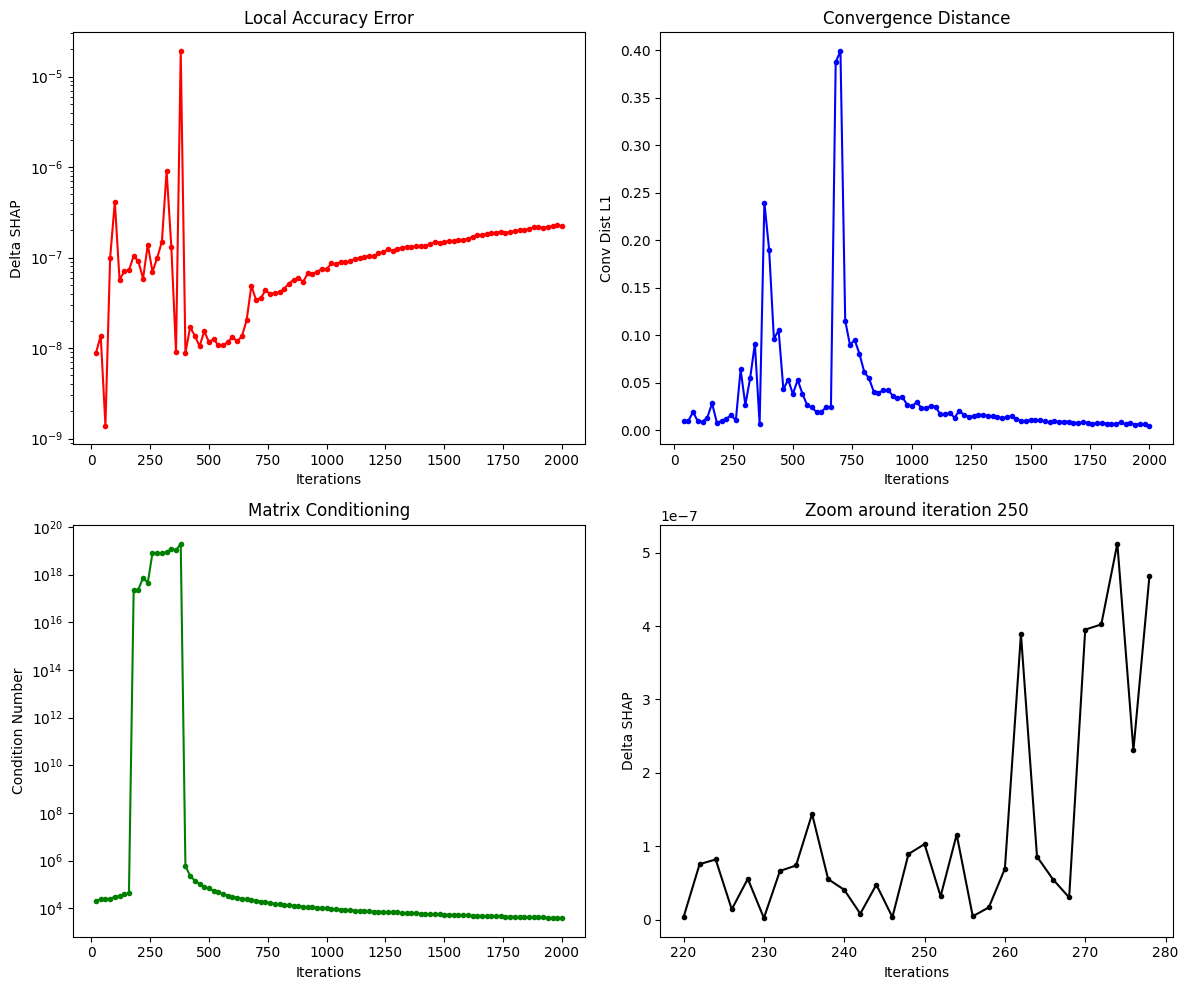


=== Additional Analysis ===
Number of unique samples: 1950
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 176
Samples with exactly 5 features active: 34
Samples with exactly 10 features active: 19
Samples with exactly 50 features active: 2
Samples with exactly 100 features active: 1
Samples with exactly 383 features active: 149

=== Samples around position 170 ===
Sample 160: sum=383, y=0.007214, w=1
Sample 161: sum=363, y=0.006553, w=1
Sample 162: sum=56, y=0.000000, w=1
Sample 163: sum=272, y=0.005593, w=1
Sample 164: sum=122, y=0.001498, w=1
Sample 165: sum=2, y=0.000000, w=1
Sample 166: sum=333, y=0.007090, w=1
Sample 167: sum=156, y=0.005760, w=1
Sample 168: sum=340, y=0.006493, w=1
Sample 169: sum=380, y=0.007226, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=1, y=0.000000, w=1
Sample 172: sum=339, y=0.007196, w=1
Sample 173: sum=46, y=0.000000, w=1
Sample 174: sum=383, y=0.007214, w=1
Sampl

In [6]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Investigate around iteration 250
window = list(range(220, 280, 2))  # every 2 iterations to save time
deltas_window = []
for n in window:
    surrogate = Ridge(alpha=0.01)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    delta = abs(y[0].item() - (phi0 + phis.sum().item()))
    deltas_window.append(delta)

axes[1,1].plot(window, deltas_window, 'k.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Delta SHAP')
axes[1,1].set_title('Zoom around iteration 250')

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):
    print(f"Sample {i}: sum={X[i].sum():.0f}, y={y[i]:.6f}, w={w[i]:.0f}")

# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [7]:
print("condition numbers:")
print(len(condition_numbers))
print(checkpoints)
print([(i, condition_numbers[i//20-1]) for i in checkpoints])

condition numbers:
100
range(20, 2001, 20)
[(20, 20319.80772988343), (40, 24137.991763569516), (60, 24331.523905354145), (80, 24995.06357091029), (100, 30788.607000158623), (120, 32394.02818898437), (140, 38479.74672383023), (160, 42375.91895019986), (180, 2.1788459472021834e+17), (200, 2.338189121121193e+17), (220, 7.447066486103569e+17), (240, 4.531441901467369e+17), (260, 8.072516502073389e+18), (280, 7.916813038413586e+18), (300, 7.702547812203298e+18), (320, 8.738990907127635e+18), (340, 1.202966041035273e+19), (360, 1.032814916676174e+19), (380, 2.001395830032993e+19), (400, 582127.6509725752), (420, 235423.00266344455), (440, 142661.51623749753), (460, 105019.73195471348), (480, 78207.42935371687), (500, 68509.34295603403), (520, 53857.71585408218), (540, 47441.96903768006), (560, 39443.95548982118), (580, 34361.748024847584), (600, 30289.266182645777), (620, 28063.053264306203), (640, 25421.240390397434), (660, 23918.942184569612), (680, 22661.983774013785), (700, 21121.2742915

In [8]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open('dataset-kernel-shap.pkl', 'rb') as f:
    ds = CPU_Unpickler(f).load()



# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(160, 180, 1)
conv_distances = []
deltas = []
condition_numbers = []

from sklearn.linear_model import LinearRegression as LinReg

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = Ridge(alpha=0.01)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([2000, 384]), y=torch.Size([2000]), w=torch.Size([2000])
Output range: [0.000000, 0.007279]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n= 160: delta=8.48e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.24e+04

n= 161: delta=1.32e-06, phi0=0.000001, sum(phis)=0.007211
        f(x)=0.007214, phi0+sum(phis)=0.007213
        Num non-zero coefs: 384
        Condition number: 4.24e+04

n= 162: delta=1.90e-07, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.31e+04

n= 163: delta=1.35e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.32e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.40858e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Usin


n= 164: delta=1.26e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.32e+04

n= 165: delta=1.12e-07, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.32e+04

n= 166: delta=3.44e-06, phi0=-0.000003, sum(phis)=0.007221
        f(x)=0.007214, phi0+sum(phis)=0.007217
        Num non-zero coefs: 384
        Condition number: 4.33e+04

n= 167: delta=6.44e-07, phi0=0.000001, sum(phis)=0.007213
        f(x)=0.007214, phi0+sum(phis)=0.007213
        Num non-zero coefs: 384
        Condition number: 4.35e+04

n= 168: delta=4.17e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.35e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.78006e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.81527e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual pr


n= 169: delta=1.35e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.40e+04

n= 170: delta=1.41e-07, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.42e+04

n= 171: delta=6.36e-07, phi0=0.000001, sum(phis)=0.007213
        f(x)=0.007214, phi0+sum(phis)=0.007213
        Num non-zero coefs: 384
        Condition number: 4.43e+04

n= 172: delta=3.21e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.45e+04

n= 173: delta=5.60e-07, phi0=0.000001, sum(phis)=0.007213
        f(x)=0.007214, phi0+sum(phis)=0.007213
        Num non-zero coefs: 384
        Condition number: 4.46e+04


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.77747e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.71283e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



n= 174: delta=2.05e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 4.46e+04

n= 175: delta=2.40e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.17e+17

n= 176: delta=5.33e-08, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.17e+17


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



n= 177: delta=6.75e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.18e+17

n= 178: delta=7.38e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.18e+17

n= 179: delta=5.82e-08, phi0=0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.18e+17


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(



=== Investigating around iteration 250==


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.43542e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.42973e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.39063e-11)

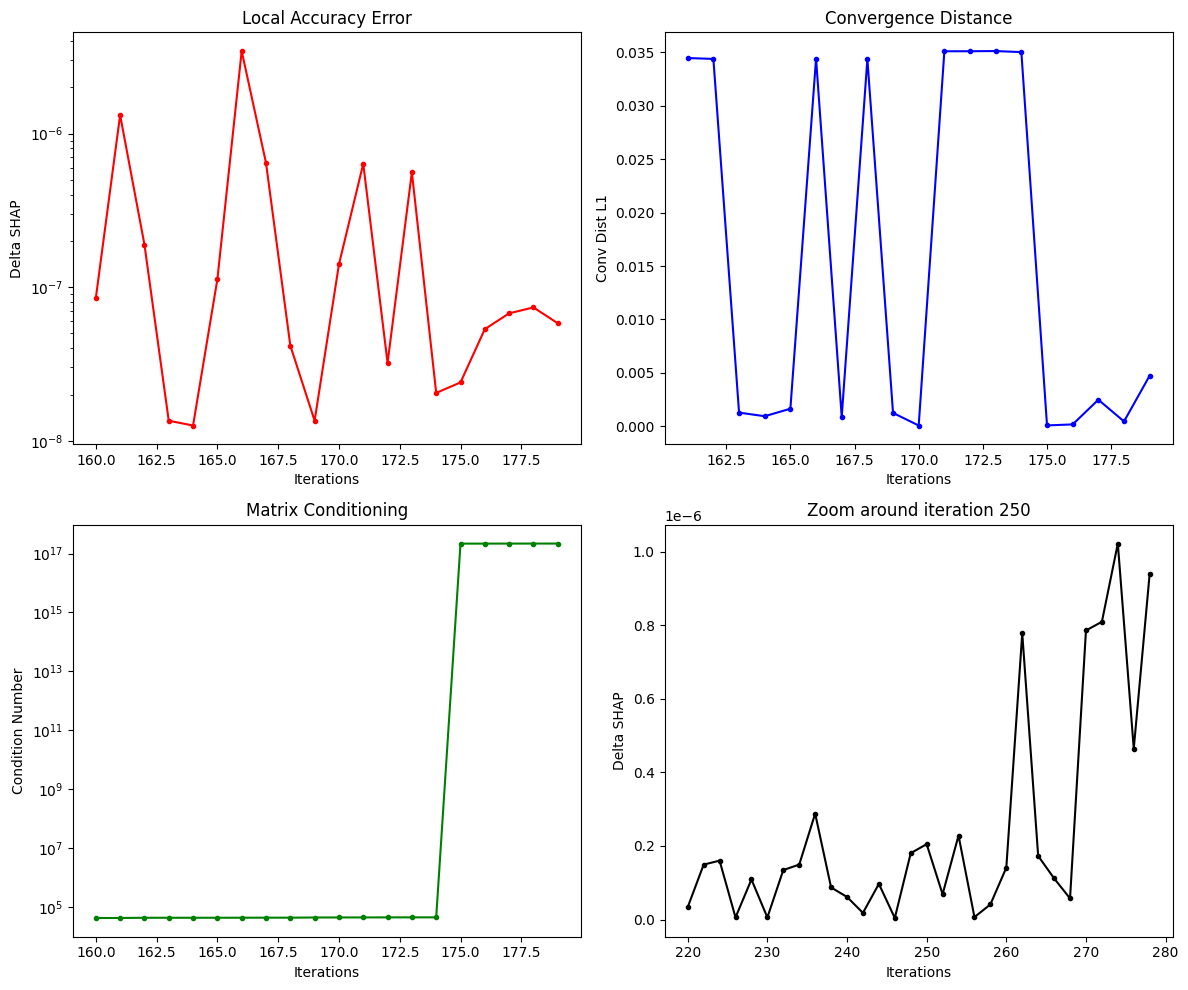


=== Additional Analysis ===
Number of unique samples: 1950
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 176
Samples with exactly 5 features active: 34
Samples with exactly 10 features active: 19
Samples with exactly 50 features active: 2
Samples with exactly 100 features active: 1
Samples with exactly 383 features active: 149

=== Samples around position 170 ===
Sample 160: sum=383, y=0.007214, w=1
Sample 161: sum=363, y=0.006553, w=1
Sample 162: sum=56, y=0.000000, w=1
Sample 163: sum=272, y=0.005593, w=1
Sample 164: sum=122, y=0.001498, w=1
Sample 165: sum=2, y=0.000000, w=1
Sample 166: sum=333, y=0.007090, w=1
Sample 167: sum=156, y=0.005760, w=1
Sample 168: sum=340, y=0.006493, w=1
Sample 169: sum=380, y=0.007226, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=1, y=0.000000, w=1
Sample 172: sum=339, y=0.007196, w=1
Sample 173: sum=46, y=0.000000, w=1
Sample 174: sum=383, y=0.007214, w=1
Sampl

In [9]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Investigate around iteration 250
print("\n=== Investigating around iteration 250==")
window = list(range(220, 280, 2))  # every 2 iterations to save time
deltas_window = []
for n in window:
    surrogate = Ridge(alpha=0.01)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    rep = surrogate.coef_
    beta = torch.as_tensor(rep, dtype=torch.float32).flatten()
    phi0 = beta[0].item()
    phis = beta[1:]
    
    delta = abs(y[0].item() - (phi0 + phis.sum().item()))
    deltas_window.append(delta)

axes[1,1].plot(window, deltas_window, 'k.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Delta SHAP')
axes[1,1].set_title('Zoom around iteration 250')

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):
    print(f"Sample {i}: sum={X[i].sum():.0f}, y={y[i]:.6f}, w={w[i]:.0f}")

# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [10]:
print("174th sample: ", X[174], y[174].item(), w[174].item())


174th sample:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1

In [11]:
print("index of the only 0 feature: ", (X[174] == 0).nonzero(as_tuple=True)[0].item())

index of the only 0 feature:  299



n=   1: phi299=0.000000, phi0=0.007214, sum(phis)=0.000000

n=   6: phi299=0.000016, phi0=0.000000, sum(phis)=0.007214

n=  11: phi299=0.000029, phi0=-0.000000, sum(phis)=0.007214

n=  16: phi299=0.000012, phi0=0.000000, sum(phis)=0.007214

n=  21: phi299=0.000013, phi0=0.000000, sum(phis)=0.007214

n=  26: phi299=0.000018, phi0=-0.000000, sum(phis)=0.007214

n=  31: phi299=0.000018, phi0=-0.000000, sum(phis)=0.007214

n=  36: phi299=0.000051, phi0=-0.000000, sum(phis)=0.007214

n=  41: phi299=-0.000018, phi0=0.000000, sum(phis)=0.007214

n=  46: phi299=-0.000017, phi0=0.000000, sum(phis)=0.007214

n=  51: phi299=0.000070, phi0=0.000000, sum(phis)=0.007214

n=  56: phi299=-0.000005, phi0=0.000000, sum(phis)=0.007214

n=  61: phi299=0.000105, phi0=0.000000, sum(phis)=0.007214

n=  66: phi299=0.000092, phi0=-0.000000, sum(phis)=0.007214

n=  71: phi299=-0.000027, phi0=0.000000, sum(phis)=0.007214

n=  76: phi299=-0.000048, phi0=0.000000, sum(phis)=0.007214

n=  81: phi299=0.000088, phi0

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.05384e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Usin


n= 161: phi299=0.000001, phi0=0.000001, sum(phis)=0.007211

n= 166: phi299=0.000004, phi0=-0.000003, sum(phis)=0.007221

n= 171: phi299=0.000000, phi0=0.000001, sum(phis)=0.007213

n= 176: phi299=0.000159, phi0=-0.000000, sum(phis)=0.007214

n= 181: phi299=-0.000000, phi0=0.000001, sum(phis)=0.007213

n= 186: phi299=0.000163, phi0=0.000000, sum(phis)=0.007214

n= 191: phi299=0.000193, phi0=0.000000, sum(phis)=0.007214

n= 196: phi299=0.000180, phi0=-0.000000, sum(phis)=0.007214


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.40858e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.78006e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.77747e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4

Text(0.5, 1.0, 'Coefficient of 299th feature over iterations')

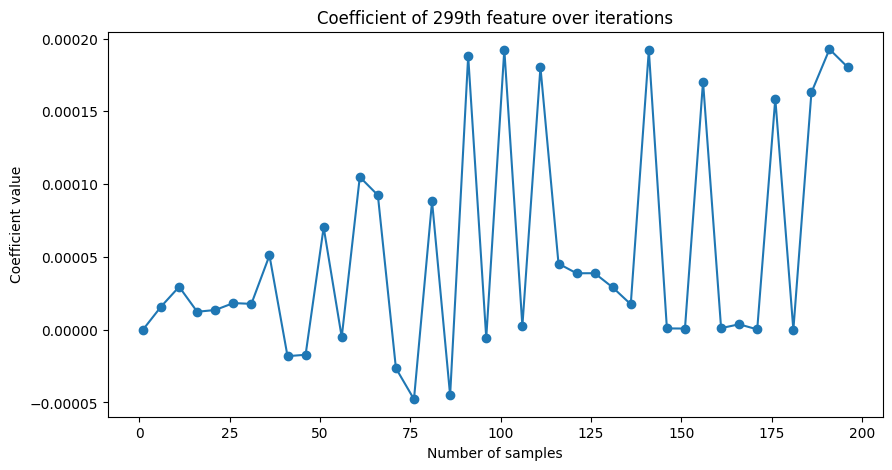

In [12]:
# examine model weight of the 299th feature from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples
    surrogate = Ridge(alpha=0.01)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phi299={phis[299].item():.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save\ the coefficient of the 299th feature
    phis_v.append(phis[299].item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Coefficient of 299th feature over iterations')


n=   1: phiavg=0.000000, phi0=0.007214, sum(phis)=0.000000

n=   6: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  11: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  16: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  21: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  26: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  31: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  36: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  41: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  46: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  51: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  56: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  61: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  66: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  71: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  76: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  81: phiavg=0.000019, phi0=-0.0

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.05384e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Usin


n= 161: phiavg=0.000019, phi0=0.000001, sum(phis)=0.007211

n= 166: phiavg=0.000019, phi0=-0.000003, sum(phis)=0.007221

n= 171: phiavg=0.000019, phi0=0.000001, sum(phis)=0.007213

n= 176: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n= 181: phiavg=0.000019, phi0=0.000001, sum(phis)=0.007213

n= 186: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n= 191: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n= 196: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214


/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=6.40858e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.78006e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.77747e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4

Text(0.5, 1.0, 'Average coefficient of features over iterations')

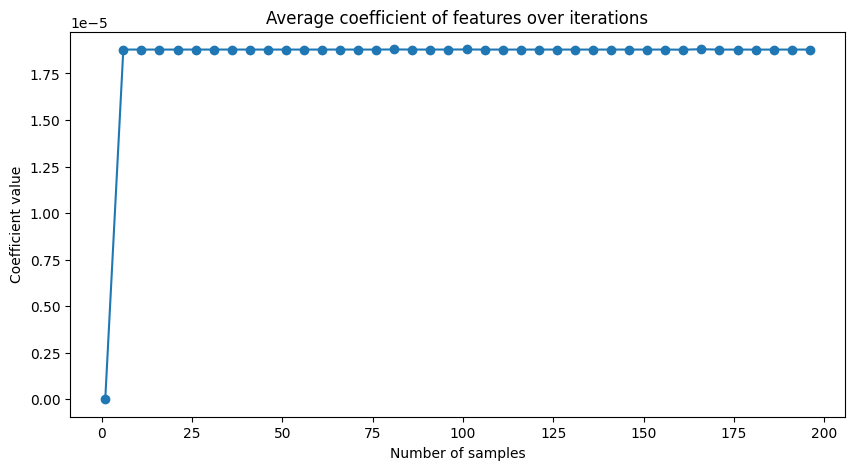

In [13]:
# examine model weight of the average of the features from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = Ridge(alpha=0.01)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phiavg={phis.mean().item():.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save the average coefficient
    phis_v.append(phis.mean().item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Average coefficient of features over iterations')

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.05384e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Usin


n=   6: phi299=0.000016, phi0=0.000000, sum(phis)=0.007214

n=  11: phi299=0.000014, phi0=-0.000000, sum(phis)=0.007214

n=  16: phi299=-0.000017, phi0=0.000000, sum(phis)=0.007214

n=  21: phi299=0.000001, phi0=0.000000, sum(phis)=0.007214

n=  26: phi299=0.000005, phi0=-0.000000, sum(phis)=0.007214

n=  31: phi299=-0.000001, phi0=-0.000000, sum(phis)=0.007214

n=  36: phi299=0.000033, phi0=-0.000000, sum(phis)=0.007214

n=  41: phi299=-0.000069, phi0=0.000000, sum(phis)=0.007214

n=  46: phi299=0.000001, phi0=0.000000, sum(phis)=0.007214

n=  51: phi299=0.000088, phi0=0.000000, sum(phis)=0.007214

n=  56: phi299=-0.000075, phi0=0.000000, sum(phis)=0.007214

n=  61: phi299=0.000110, phi0=0.000000, sum(phis)=0.007214

n=  66: phi299=-0.000012, phi0=-0.000000, sum(phis)=0.007214

n=  71: phi299=-0.000119, phi0=0.000000, sum(phis)=0.007214

n=  76: phi299=-0.000021, phi0=0.000000, sum(phis)=0.007214

n=  81: phi299=0.000136, phi0=-0.000001, sum(phis)=0.007216

n=  86: phi299=-0.000133, 

/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.78006e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=5.77747e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=4.62542e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/giulio/anaconda3/envs/torch/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solv

Text(0.5, 1.0, 'Variation of the coefficient of 299th feature over iterations')

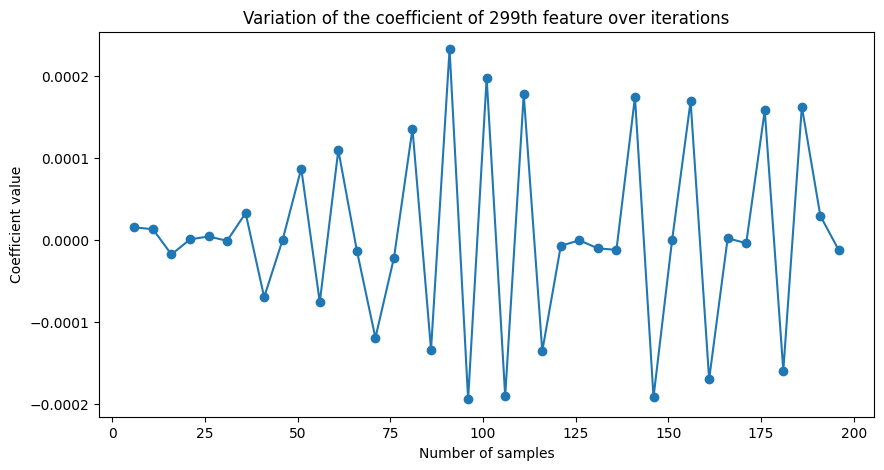

In [14]:
# examine model weight differences of the features from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
idx = 299  # index of the feature to analyze
phi_prev = None
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = Ridge(alpha=0.01)
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    if phi_prev is not None:
        phi = phis[idx] - phi_prev
        print(f"\nn={n:4d}: phi299={phi:.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

        # save the coefficient of the 299th feature
        phis_v.append(phi.item())
    
    phi_prev = phis[idx].clone()

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints[1:], phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Variation of the coefficient of 299th feature over iterations')